In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, classification_report, roc_curve
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, BaggingClassifier

In [2]:
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
#from mlxtend.classifier import StackingClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
train_path = '/Users/raisaurabh04/OneDrive/GreyAtom/Practice Dataset/greyatom_hackaton/file/train.csv'
test_path = '/Users/raisaurabh04/OneDrive/GreyAtom/Practice Dataset/greyatom_hackaton/file/test.csv'

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
train_df.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,NaN,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,NaN,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,NaN,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,NaN,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


In [6]:
def update_null_values() :
    
    nulls_in_train_data = train_df.isna().sum()[train_df.isna().sum() > 0]
    nulls_in_test_data = train_df.isna().sum()[train_df.isna().sum() > 0]
    null_value_count = pd.concat(objs=[nulls_in_train_data.rename('Training Dataset'), nulls_in_test_data.rename('Testing Dataset')], axis=1, 
              join='outer', sort=True)
    return null_value_count

In [7]:
update_null_values()

,Training Dataset,Testing Dataset
Gender,35953,35953


In [8]:
train_df.shape

(50553, 12)

In [9]:
test_df.isna().sum()

ID                         0
Agency                     0
Agency Type                0
Distribution Channel       0
Product Name               0
Duration                   0
Destination                0
Net Sales                  0
Commision (in value)       0
Gender                  9056
Age                        0
dtype: int64

In [10]:
test_df.shape

(12661, 11)

In [11]:
test_df.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,25902,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,58,ICELAND,49.5,29.7,NaN,47
1,19535,EPX,Travel Agency,Online,2 way Comprehensive Plan,4,SINGAPORE,20.0,0.0,NaN,24
2,43717,EPX,Travel Agency,Online,2 way Comprehensive Plan,68,VIET NAM,20.0,0.0,NaN,36
3,48271,EPX,Travel Agency,Online,2 way Comprehensive Plan,41,CHINA,28.0,0.0,NaN,36
4,52318,EPX,Travel Agency,Online,Cancellation Plan,16,SINGAPORE,11.0,0.0,NaN,36


In [12]:
train_df.corr()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
ID,1.000000,0.040265,0.029771,0.084391,0.114668,0.009026
Claim,0.040265,1.000000,0.076442,0.138323,0.102009,-0.012106
Duration,0.029771,0.076442,1.000000,0.437004,0.349193,0.003212
Net Sales,0.084391,0.138323,0.437004,1.000000,0.657851,0.039119
Commision (in value),0.114668,0.102009,0.349193,0.657851,1.000000,0.119167
Age,0.009026,-0.012106,0.003212,0.039119,0.119167,1.000000


In [13]:
train_df.skew()

ID                       0.000141
Claim                    8.077216
Duration                22.872743
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

In [14]:
train_df['Claim'].value_counts()

0    49812
1      741
Name: Claim, dtype: int64

In [15]:
train_df.describe()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
count,50553.000000,50553.000000,50553.000000,50553.000000,50553.00000,50553.000000
mean,31679.740134,0.014658,49.425969,40.800977,9.83809,40.011236
std,18288.265350,0.120180,101.434647,48.899683,19.91004,14.076566
min,0.000000,0.000000,-2.000000,-389.000000,0.00000,0.000000
25%,15891.000000,0.000000,9.000000,18.000000,0.00000,35.000000
50%,31657.000000,0.000000,22.000000,26.500000,0.00000,36.000000
75%,47547.000000,0.000000,53.000000,48.000000,11.55000,44.000000
max,63325.000000,1.000000,4881.000000,810.000000,283.50000,118.000000


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50553 entries, 0 to 50552
Data columns (total 12 columns):
ID                      50553 non-null int64
Agency                  50553 non-null object
Agency Type             50553 non-null object
Distribution Channel    50553 non-null object
Product Name            50553 non-null object
Claim                   50553 non-null int64
Duration                50553 non-null int64
Destination             50553 non-null object
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Gender                  14600 non-null object
Age                     50553 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 4.6+ MB


In [17]:
#dropping since max data is NaN
train_df.drop(columns='Gender', inplace=True)

test_df.drop(columns='Gender', inplace=True)

In [18]:
cat_cols = train_df.select_dtypes(exclude=np.number).columns
len(cat_cols)

5

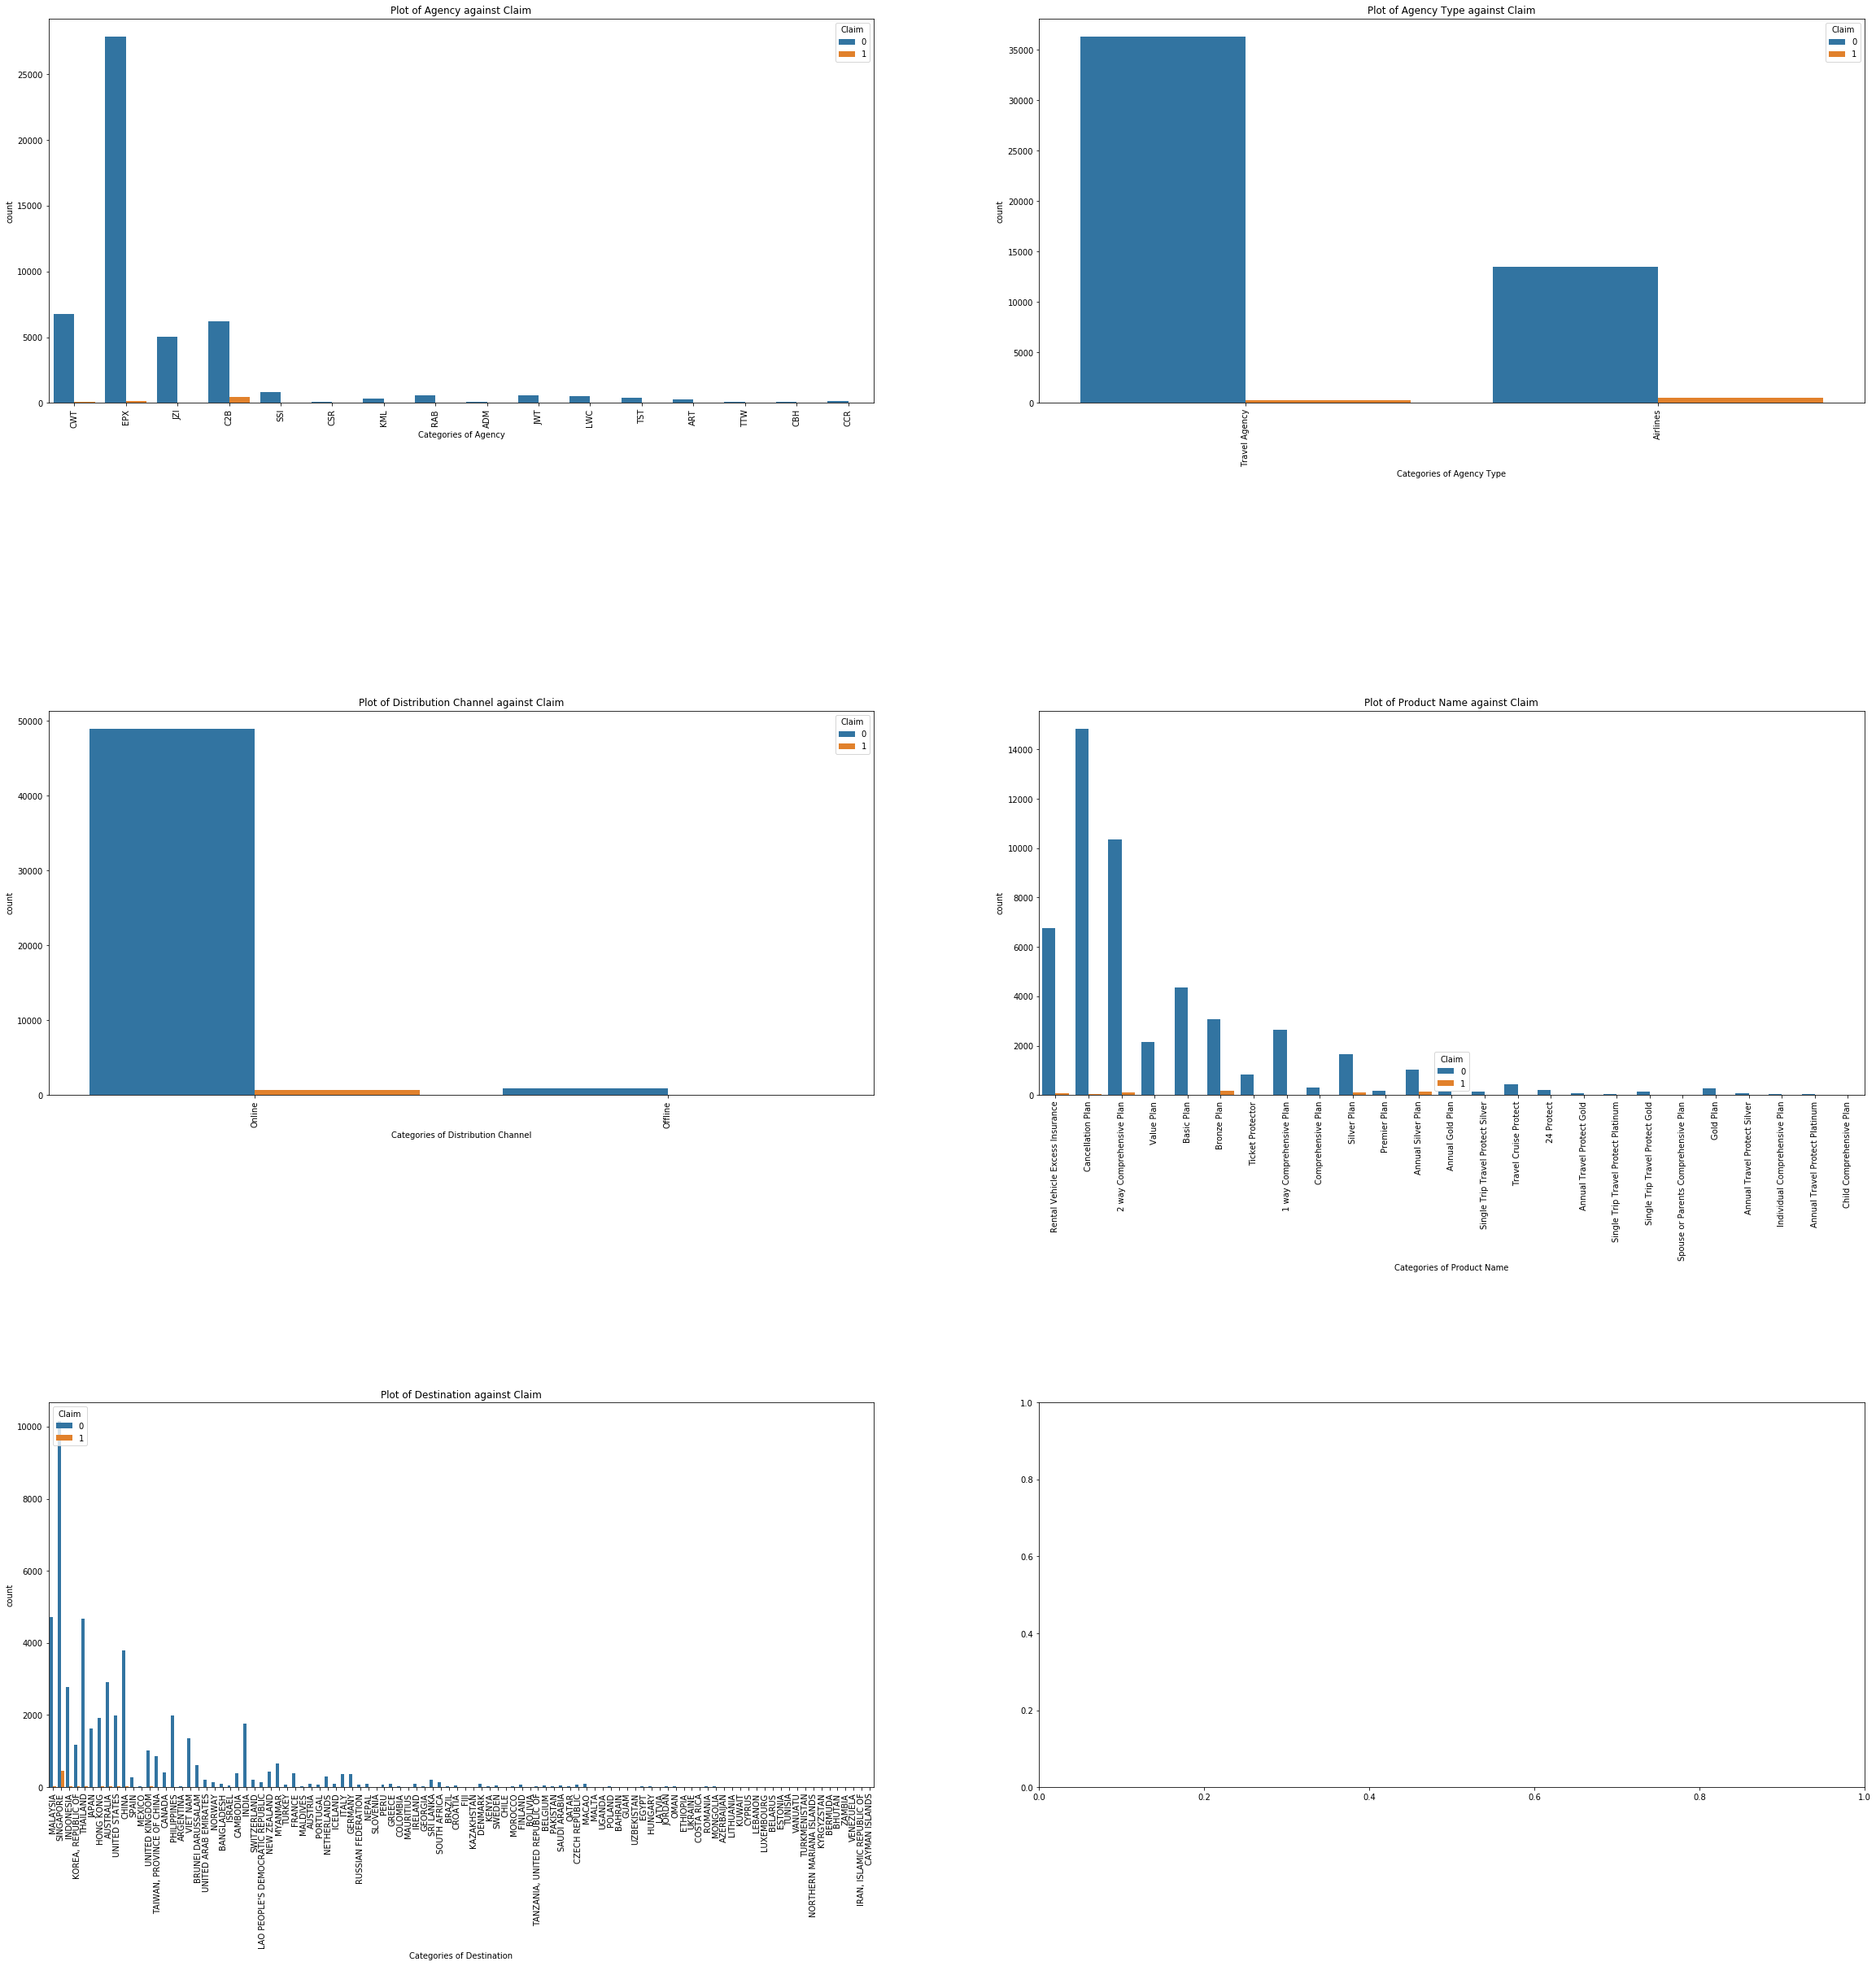

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(40, 40))
plt.subplots_adjust(hspace=0.8)
for i, j in np.ndindex(axes.shape):
    if (2*i + j) < len(cat_cols):
        #print(i, j, cat_cols[2*i + j], axes[i, j])
        plot = sns.countplot(x = train_df[cat_cols[2 * i + j]], hue=train_df['Claim'], ax = axes[i, j])
        axes[i, j].set(title='Plot of {} against Claim'.format(cat_cols[2 * i + j]), 
                   xlabel='Categories of {}'.format(cat_cols[2 * i + j]))
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)       

In [20]:
num_cols = train_df.select_dtypes(include=np.number).columns

In [21]:
train_df.select_dtypes(include=np.number).head()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
0,3433,0,7,0.0,17.82,31
1,4339,0,85,69.0,0.00,36
2,34590,0,11,19.8,11.88,75
3,55816,0,16,20.0,0.00,32
4,13816,0,10,15.0,0.00,29


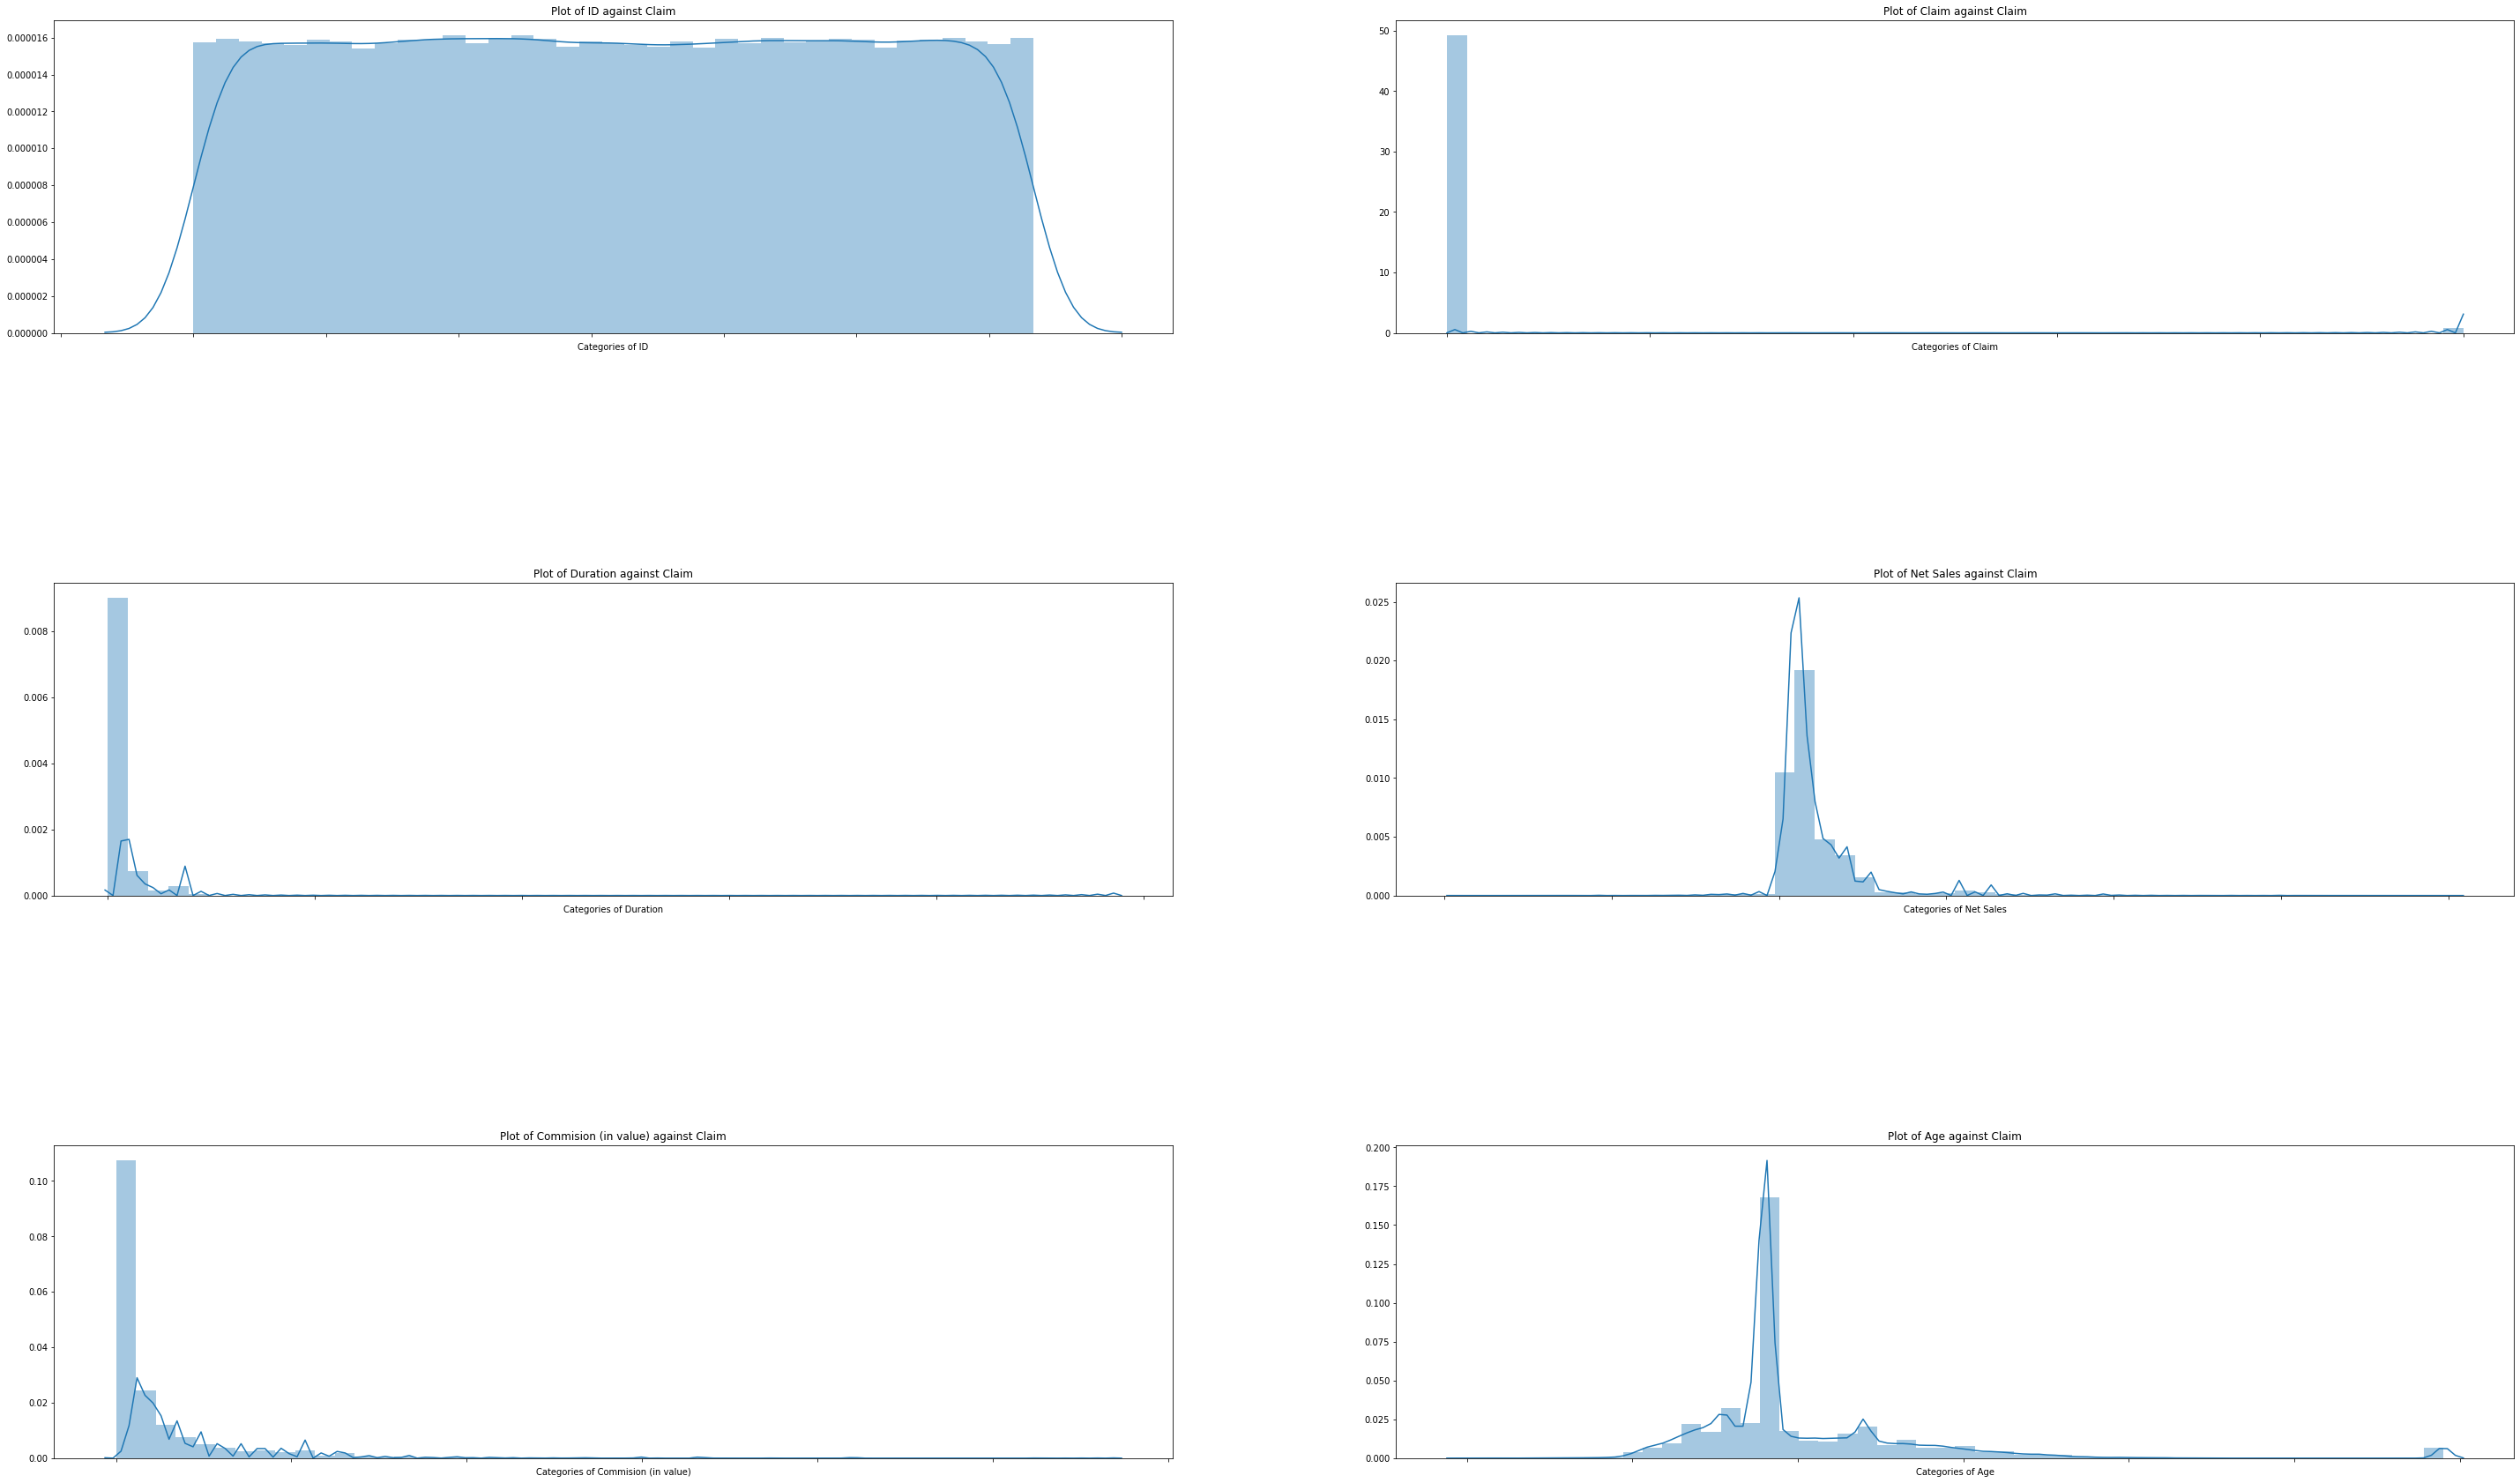

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 30))
plt.subplots_adjust(hspace=0.8)
for i, j in np.ndindex(axes.shape):
    if (2*i + j) < len(num_cols):
        #print(num_cols[2*i + j])
        plot = sns.distplot(a = train_df[num_cols[2*i + j]], ax = axes[i, j])
        axes[i, j].set(title='Plot of {} against Claim'.format(num_cols[2*i + j]), 
                   xlabel='Categories of {}'.format(num_cols[2*i + j]))
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

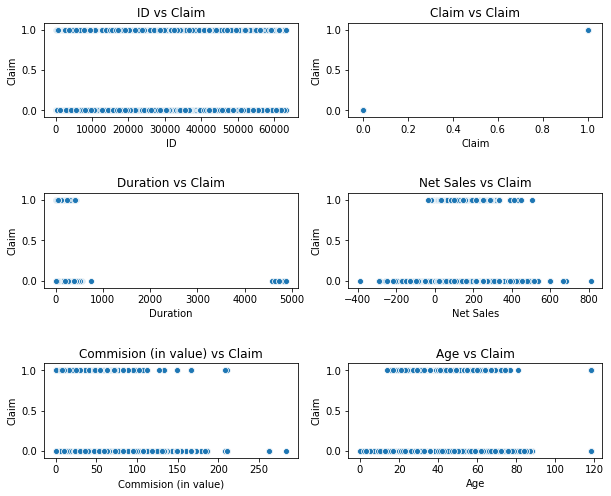

In [23]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 8))
plt.subplots_adjust(hspace=0.8)
for i,j in np.ndindex(axes.shape):
    if (2*i + j) < len(num_cols):
        #print(num_cols[2*i + j])
        plot = sns.scatterplot(x=train_df[num_cols[2*i + j]], y=train_df['Claim'], ax=axes[i,j])
        axes[i, j].set(xlabel = num_cols[2*i + j], ylabel = 'Claim', title = '{} vs Claim'.format(num_cols[2*i + j]))
        
plt.show()

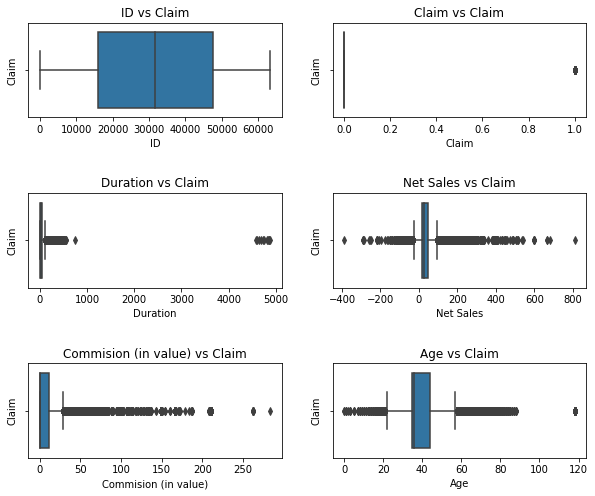

In [24]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 8))
plt.subplots_adjust(hspace=0.8)
for i,j in np.ndindex(axes.shape):
    if (2*i + j) < len(num_cols):
        #print(num_cols[2*i + j])
        plot = sns.boxplot(x=train_df[num_cols[2*i + j]], hue=train_df['Claim'], ax=axes[i,j])
        axes[i, j].set(xlabel = num_cols[2*i + j], ylabel = 'Claim', title = '{} vs Claim'.format(num_cols[2*i + j]))
        
plt.show()

In [25]:
# fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 8))
# plt.subplots_adjust(hspace=0.8)
# for i,j in np.ndindex(axes.shape):
#     if (2*i + j) < len(num_cols):
#         #print(num_cols[2*i + j])
#         plot = sns.violinplot(x=train_df[num_cols[2*i + j]], y=train_df['Claim'], ax=axes[i,j])
#         axes[i, j].set(xlabel = num_cols[2*i + j], ylabel = 'Claim', title = '{} vs Claim'.format(num_cols[2*i + j]))
        
# plt.show()

In [26]:
train_df.skew()

ID                       0.000141
Claim                    8.077216
Duration                22.872743
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

In [27]:
test_df.skew()

ID                      -0.003255
Duration                24.302750
Net Sales                3.067173
Commision (in value)     3.836536
Age                      3.013940
dtype: float64

In [28]:
update_null_values()

,Training Dataset,Testing Dataset


In [29]:
def negative_removal(dataframe, column):
    '''Function which takes a dataframe and column name as parameter and replace the negative values with zero'''
    for index in dataframe[dataframe[column] < 0].index.values:
        dataframe.loc[index, column] = 0

In [30]:
#removing negative values from Duration since it cannot be negative
negative_removal(dataframe=train_df, column='Duration') 
negative_removal(dataframe=test_df, column='Duration')

In [31]:
train_df[train_df['Duration'] <= 0].shape #to be removed in next iteration

(57, 11)

In [32]:
train_df[(train_df['Duration'] <= 0) | (train_df['Age'] <= 0)].index

Int64Index([  181,   314,  1362,  1864,  3068,  4063,  4282,  7324,  7482,
             7885,  8205,  8512,  8897,  9501, 10465, 10558, 11515, 12579,
            12924, 16251, 17641, 17741, 18198, 18299, 19419, 20538, 21442,
            23561, 23606, 23766, 24505, 25266, 25785, 26076, 27002, 30597,
            31258, 31932, 33674, 34178, 34511, 36144, 36403, 38935, 39014,
            39027, 39318, 41302, 41861, 43410, 43464, 43485, 43719, 45395,
            45474, 45828, 47625, 48367, 50357],
           dtype='int64')

In [33]:
train_df.columns

Index(['ID', 'Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Age'],
      dtype='object')

In [34]:
train_df.drop_duplicates(subset=['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Age'])['Claim'].value_counts()

0    43725
1      738
Name: Claim, dtype: int64

In [35]:
train_df['Claim'].value_counts()

0    49812
1      741
Name: Claim, dtype: int64

In [36]:
test_df[test_df['Duration'] <= 0].shape

(9, 10)

In [37]:
train_df.describe()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
count,50553.000000,50553.000000,50553.000000,50553.000000,50553.00000,50553.000000
mean,31679.740134,0.014658,49.426048,40.800977,9.83809,40.011236
std,18288.265350,0.120180,101.434608,48.899683,19.91004,14.076566
min,0.000000,0.000000,0.000000,-389.000000,0.00000,0.000000
25%,15891.000000,0.000000,9.000000,18.000000,0.00000,35.000000
50%,31657.000000,0.000000,22.000000,26.500000,0.00000,36.000000
75%,47547.000000,0.000000,53.000000,48.000000,11.55000,44.000000
max,63325.000000,1.000000,4881.000000,810.000000,283.50000,118.000000


In [38]:
X = train_df.drop(columns='Claim', inplace=False)
y = train_df['Claim']

In [39]:
X.skew()

ID                       0.000141
Duration                22.872767
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

In [40]:
skewed_data = X.skew()[(X.skew() > 1) | (X.skew() < -1)]
skewed_data

Duration                22.872767
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

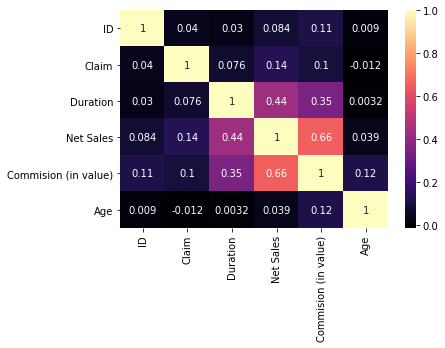

In [41]:
sns.heatmap(data=train_df.corr(), annot=True, cmap='magma')

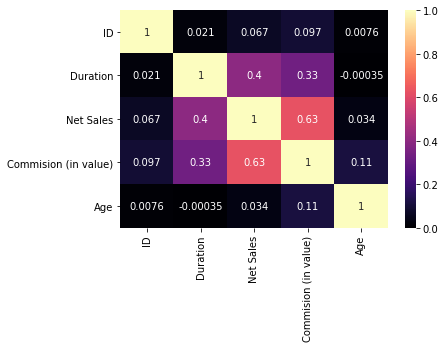

In [42]:
sns.heatmap(data=test_df.corr(), annot=True, cmap='magma')

In [43]:
def find_columns_with_negative_values(dataframe) :
    '''Method to find columns that have negative values'''
    columns_with_negative_values = []
    for cols in dataframe.select_dtypes(include=np.number) :
        if dataframe[cols].min() < 0:
            columns_with_negative_values.append(cols)
    return columns_with_negative_values


In [44]:
train_columns_with_negative_values = find_columns_with_negative_values(train_df)

In [45]:
train_columns_with_negative_values

['Net Sales']

In [46]:
yeo_john = PowerTransformer(method='yeo-johnson')

In [47]:
def standardize_distribution_tranformation(dataframe):
    '''Removing skewness to get a normal distribution'''
    for cols in dataframe.select_dtypes(include=np.number):
        #print(cols)
        dataframe[cols] = yeo_john.fit(dataframe[[cols]]).transform(dataframe[[cols]]) #Yeo - Johnson for -ve data
    return dataframe

In [48]:
X.iloc[ : , 1 : ] = standardize_distribution_tranformation(X.iloc[ : , 1 : ])

In [49]:
X.iloc[ : , 1 : ].select_dtypes(include=np.number).head()

,Duration,Net Sales,Commision (in value),Age
0,-0.964880,-0.877699,1.220046,-0.729697
1,1.075893,0.615039,-0.865401,-0.186148
2,-0.588904,-0.401191,1.070456,2.251739
3,-0.275376,-0.396766,-0.865401,-0.612941
4,-0.668578,-0.508728,-0.865401,-0.977328


In [50]:
train_df.skew()

ID                       0.000141
Claim                    8.077216
Duration                22.872767
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

In [51]:
X.skew()

ID                      0.000141
Duration                0.010686
Net Sales               1.357545
Commision (in value)    0.378785
Age                    -0.255397
dtype: float64

In [52]:
label_encoder = LabelEncoder()

In [53]:
for cols in X.select_dtypes(exclude=np.number):
    X[cols] = label_encoder.fit_transform(X[cols])

In [54]:
X.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,3433,6,1,1,16,-0.964880,56,-0.877699,1.220046,-0.729697
1,4339,7,1,1,10,1.075893,79,0.615039,-0.865401,-0.186148
2,34590,6,1,1,16,-0.588904,56,-0.401191,1.070456,2.251739
3,55816,7,1,1,1,-0.275376,38,-0.396766,-0.865401,-0.612941
4,13816,7,1,1,10,-0.668578,47,-0.508728,-0.865401,-0.977328


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

In [56]:
#using smote sampling
sm = SMOTE(random_state = 30)

X_train_res, y_train_res = sm.fit_sample(X_train.iloc[ : , 1 : ], y_train)

In [57]:
def metric_data(y_true, y_pred):
    '''Method takes expected and actual output as parameters and provides all the relevant classification metrices'''
    #accuracy_score,classification_report,f1_score,confusion_matrix
    acc_score = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = f1_score(y_true, y_pred)
    prec_score = precision_score(y_true, y_pred)
    rec_score = recall_score(y_true, y_pred)
    roc_score = roc_auc_score(y_true, y_pred)
    classifn_report = classification_report(y_true, y_pred)
    print('Accuracy is ',acc_score)
    print('Precision Score is ', prec_score)
    print('F1 Score is ', f1)
    print('Recall Score is ', rec_score)
    print('Area under ROC Curve is ', roc_score)
    print('Confusion Matrix is ')
    print(tp, fp)
    print(fn, tn)
    print('Classification Report is ')
    print(classifn_report)


In [58]:
lr = LogisticRegression(random_state=30)

lr.fit(X_train_res, y_train_res.ravel())

y_pred_logreg = lr.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_logreg)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is  0.804371476609633
Precision Score is  0.05490767735665695
F1 Score is  0.10254083484573503
Recall Score is  0.773972602739726
Area under ROC Curve is  0.7893947308731244
Confusion Matrix is 
113 1945
33 8020
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      9965
           1       0.05      0.77      0.10       146

    accuracy                           0.80     10111
   macro avg       0.53      0.79      0.50     10111
weighted avg       0.98      0.80      0.88     10111



In [59]:
param_grid_logreg = {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100]}

grid_search_log_reg = GridSearchCV(LogisticRegression(), param_grid=param_grid_logreg, cv=5, verbose=5, n_jobs=-1)

grid_search_log_reg.fit(X_train_res, y_train_res.ravel())

y_pred_logreg_gs = grid_search_log_reg.predict(X_test.iloc[ : , 1 :])

grid_search_log_reg.best_params_

metric_data(y_test, y_pred_logreg)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   42.9s finished
/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is  0.804371476609633
Precision Score is  0.05490767735665695
F1 Score is  0.10254083484573503
Recall Score is  0.773972602739726
Area under ROC Curve is  0.7893947308731244
Confusion Matrix is 
113 1945
33 8020
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      9965
           1       0.05      0.77      0.10       146

    accuracy                           0.80     10111
   macro avg       0.53      0.79      0.50     10111
weighted avg       0.98      0.80      0.88     10111



In [60]:
params_grid_dt = {'max_depth' : range(2, 15), 'criterion' : ['gini', 'entropy']}
params_grid_dt

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=30), param_grid=params_grid_dt, cv=5)

grid_search_dt.fit(X_train_res, y_train_res.ravel())

y_pred_dt = grid_search_dt.predict(X_test.iloc[ : , 1 : ])

grid_search_dt.best_params_

metric_data(y_test, y_pred_dt)

Accuracy is  0.8405696765898526
Precision Score is  0.05521844660194175
F1 Score is  0.10144927536231885
Recall Score is  0.6232876712328768
Area under ROC Curve is  0.7335204036043963
Confusion Matrix is 
91 1557
55 8408
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      9965
           1       0.06      0.62      0.10       146

    accuracy                           0.84     10111
   macro avg       0.52      0.73      0.51     10111
weighted avg       0.98      0.84      0.90     10111



In [61]:
rfc = RandomForestClassifier(criterion='gini', max_depth= 6, max_features= 'auto', n_estimators= 11, random_state=30)

rfc.fit(X_train_res, y_train_res.ravel())

y_pred_rfc = rfc.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_rfc)

rfc.feature_importances_

Accuracy is  0.8443279596479082
Precision Score is  0.06516443361753958
F1 Score is  0.11968680089485458
Recall Score is  0.7328767123287672
Area under ROC Curve is  0.7894187876746694
Confusion Matrix is 
107 1535
39 8430
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.85      0.91      9965
           1       0.07      0.73      0.12       146

    accuracy                           0.84     10111
   macro avg       0.53      0.79      0.52     10111
weighted avg       0.98      0.84      0.90     10111



array([0.26638121, 0.11058125, 0.01665634, 0.0898735 , 0.04033746,
       0.08902117, 0.18498865, 0.16253809, 0.03962232])

In [62]:
lr.coef_

array([[-1.67976328e-01, -5.20118490e-01, -1.36070538e+00,
        -1.99588962e-02,  1.49164493e-01,  1.13401933e-03,
         3.19080939e-01,  3.70264840e-01, -1.68821286e-01]])

In [63]:
param_grid_rfc = { 
'n_estimators': [11,12,13],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,6,7,8],
'criterion' :['gini', 'entropy']
}

grid_search_rfc = GridSearchCV(RandomForestClassifier(random_state=30), param_grid=param_grid_rfc)

grid_search_rfc.fit(X_train_res, y_train_res.ravel())

grid_search_rfc.best_params_

y_pred_rfc_gs = grid_search_rfc.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_rfc_gs)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy is  0.8548115913361686
Precision Score is  0.06740837696335078
F1 Score is  0.12305854241338111
Recall Score is  0.7054794520547946
Area under ROC Curve is  0.781239475149324
Confusion Matrix is 
103 1425
43 8540
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      9965
           1       0.07      0.71      0.12       146

    accuracy                           0.85     10111
   macro avg       0.53      0.78      0.52     10111
weighted avg       0.98      0.85      0.91     10111



In [64]:
grid_search_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 12}

In [65]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

classifiers_smote = {'GridSearch Logistic Regression': grid_search_log_reg, 
              'GridSearch Decision Tree': grid_search_dt,
              'Logistic Regression' : lr,
              'Random Forest Classifier' : rfc,
              'GridSearch Random Forest' : grid_search_rfc}  

In [66]:
for key, value in classifiers_smote.items():
    #model = cls.fit(X_train_res, y_train_res.ravel())
    #predicted probabilities for each class for each sample. Output is an array of [n_samples, n_classes]
    yproba = value.predict_proba(X_test.iloc[ : , 1 : ])[::,1] # to select probability estimates of the positive class
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':key,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

In [67]:
result_table

,classifiers,fpr,tpr,auc
0,GridSearch Logistic Regression,"[0.0, 0.00010035122930255896, 0.00060210737581...","[0.0, 0.0, 0.0, 0.0136986301369863, 0.01369863...",0.843769
1,GridSearch Decision Tree,"[0.0, 0.004616156547917712, 0.0047165077772202...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082...",0.753384
2,Logistic Regression,"[0.0, 0.00010035122930255896, 0.00060210737581...","[0.0, 0.0, 0.0, 0.0136986301369863, 0.01369863...",0.843710
3,Random Forest Classifier,"[0.0, 0.016056196688409432, 0.0170597089814350...","[0.0, 0.18493150684931506, 0.18493150684931506...",0.859435
4,GridSearch Random Forest,"[0.0, 0.004917210235825389, 0.0050175614651279...","[0.0, 0.0410958904109589, 0.04794520547945205,...",0.855880


In [68]:
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table

,fpr,tpr,auc
classifiers,,,
GridSearch Logistic Regression,"[0.0, 0.00010035122930255896, 0.00060210737581...","[0.0, 0.0, 0.0, 0.0136986301369863, 0.01369863...",0.843769
GridSearch Decision Tree,"[0.0, 0.004616156547917712, 0.0047165077772202...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082...",0.753384
Logistic Regression,"[0.0, 0.00010035122930255896, 0.00060210737581...","[0.0, 0.0, 0.0, 0.0136986301369863, 0.01369863...",0.843710
Random Forest Classifier,"[0.0, 0.016056196688409432, 0.0170597089814350...","[0.0, 0.18493150684931506, 0.18493150684931506...",0.859435
GridSearch Random Forest,"[0.0, 0.004917210235825389, 0.0050175614651279...","[0.0, 0.0410958904109589, 0.04794520547945205,...",0.855880


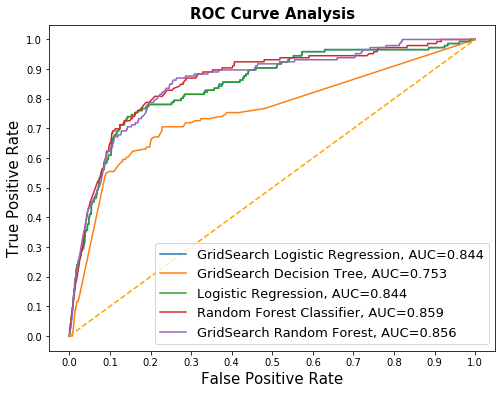

In [69]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [70]:
Counter(y_train_res), Counter(y_train)

(Counter({0: 39847, 1: 39847}), Counter({0: 39847, 1: 595}))

In [71]:
def roc_auc_curve_plot_data(classifiers):
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#     classifiers = {'GridSearch Logistic Regression': grid_search_log_reg, 
#                   'GridSearch Decision Tree': grid_search_dt,
#                   'Logistic Regression' : lr,
#                   'Random Forest Classifier' : rfc,
#                   'GridSearch Random Forest' : grid_search_rfc}  

    for key, value in classifiers.items():
        #model = cls.fit(X_train_res, y_train_res.ravel())
        #predicted probabilities for each class for each sample. Output is an array of [n_samples, n_classes]
        yproba = value.predict_proba(X_test.iloc[ : , 1 : ])[::,1] # to select probability estimates of the positive class

        fpr, tpr, _ = roc_curve(y_test,  yproba)
        auc = roc_auc_score(y_test, yproba)

        result_table = result_table.append({'classifiers':key,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    return result_table

In [72]:
def plot_roc_auc_curve(result_table) :
    fig = plt.figure(figsize=(8,6))

    #for loop to plot all the points on the curve
    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    #plotting y = x line
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [73]:
#using sklearn pipeline, a RFC on unbalanced dataset 
pipeline = make_pipeline(RandomForestClassifier(random_state=30))

rfc_pipeline_model = pipeline.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_rfc_pipeline = rfc_pipeline_model.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_rfc_pipeline)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is  0.9836811393531797
Precision Score is  0.08695652173913043
F1 Score is  0.023668639053254437
Recall Score is  0.0136986301369863
Area under ROC Curve is  0.5057956271608163
Confusion Matrix is 
2 21
144 9944
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.09      0.01      0.02       146

    accuracy                           0.98     10111
   macro avg       0.54      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



In [74]:
classifiers = {'Unbalanced RFC Pipeline Model': rfc_pipeline_model, 
                  'Random Forest Classifier' : rfc,
                  'GridSearch Random Forest' : grid_search_rfc}

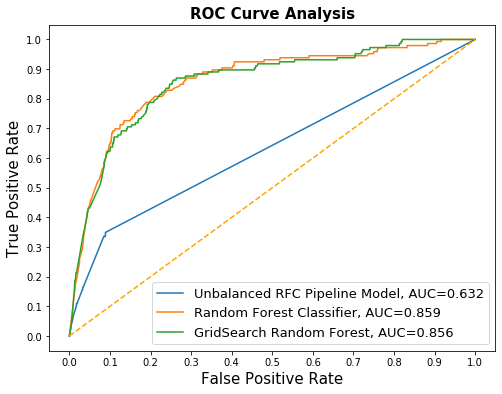

In [75]:
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

In [76]:
#model build using smote & RFC
smote_rfc_pipeline = make_pipeline_imb(SMOTE(random_state=30), RandomForestClassifier(random_state=30))

smote_rfc_pipeline_model = smote_rfc_pipeline.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_smote_rfc_pipeline = smote_rfc_pipeline_model.predict(X_test.iloc[ : , 1 :])

metric_data(y_test, y_pred_smote_rfc_pipeline)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is  0.9622193650479676
Precision Score is  0.07246376811594203
F1 Score is  0.09478672985781991
Recall Score is  0.136986301369863
Area under ROC Curve is  0.555648193334204
Confusion Matrix is 
20 256
126 9709
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9965
           1       0.07      0.14      0.09       146

    accuracy                           0.96     10111
   macro avg       0.53      0.56      0.54     10111
weighted avg       0.97      0.96      0.97     10111



In [77]:
classifiers['SMOTE RFC Pipeline'] = smote_rfc_pipeline_model

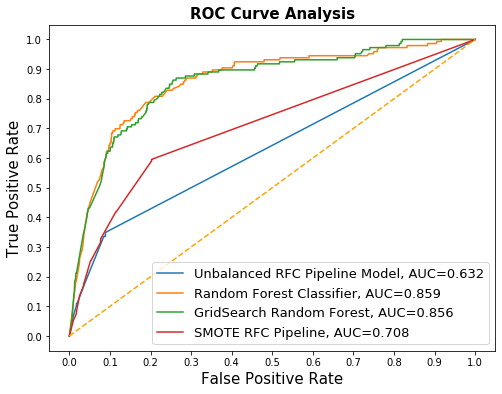

In [78]:
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

In [79]:
n_estimator_pca = range(1, X.iloc[ : , 1 : ].shape[1] + 1)

In [80]:
for n in n_estimator_pca:
    pca = PCA(n_components= n)
    pca_rfc_pipeline = make_pipeline(pca, RandomForestClassifier(random_state=30))
    pca_rfc_pipeline_model = pca_rfc_pipeline.fit(X_train.iloc[ : , 1 : ], y_train)
    y_pred_pca_rfc_pipeline = pca_rfc_pipeline_model.predict(X_test.iloc[ : , 1 : ])
    print('Metrics for N = {} is '.format(n))
    metric_data(y_test, y_pred_pca_rfc_pipeline)
    print('='*50)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 1 is 
Accuracy is  0.9772524972801899
Precision Score is  0.0625
F1 Score is  0.049586776859504134
Recall Score is  0.0410958904109589
Area under ROC Curve is  0.5160321398868642
Confusion Matrix is 
6 90
140 9875
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9965
           1       0.06      0.04      0.05       146

    accuracy                           0.98     10111
   macro avg       0.52      0.52      0.52     10111
weighted avg       0.97      0.98      0.97     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 2 is 
Accuracy is  0.9834833349817032
Precision Score is  0.08
F1 Score is  0.023391812865497075
Recall Score is  0.0136986301369863
Area under ROC Curve is  0.5056952759315138
Confusion Matrix is 
2 23
144 9942
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.08      0.01      0.02       146

    accuracy                           0.98     10111
   macro avg       0.53      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 3 is 
Accuracy is  0.9835822371674414
Precision Score is  0.08333333333333333
F1 Score is  0.023529411764705882
Recall Score is  0.0136986301369863
Area under ROC Curve is  0.505745451546165
Confusion Matrix is 
2 22
144 9943
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.08      0.01      0.02       146

    accuracy                           0.98     10111
   macro avg       0.53      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 4 is 
Accuracy is  0.9839778459103946
Precision Score is  0.13636363636363635
F1 Score is  0.03571428571428571
Recall Score is  0.02054794520547945
Area under ROC Curve is  0.5093206359243654
Confusion Matrix is 
3 19
143 9946
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.14      0.02      0.04       146

    accuracy                           0.98     10111
   macro avg       0.56      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 5 is 
Accuracy is  0.983780041538918
Precision Score is  0.09090909090909091
F1 Score is  0.023809523809523808
Recall Score is  0.0136986301369863
Area under ROC Curve is  0.5058458027754676
Confusion Matrix is 
2 20
144 9945
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.09      0.01      0.02       146

    accuracy                           0.98     10111
   macro avg       0.54      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 6 is 
Accuracy is  0.9840767480961329
Precision Score is  0.14285714285714285
F1 Score is  0.03592814371257485
Recall Score is  0.02054794520547945
Area under ROC Curve is  0.5093708115390168
Confusion Matrix is 
3 18
143 9947
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.14      0.02      0.04       146

    accuracy                           0.98     10111
   macro avg       0.56      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 7 is 
Accuracy is  0.9838789437246563
Precision Score is  0.09523809523809523
F1 Score is  0.023952095808383235
Recall Score is  0.0136986301369863
Area under ROC Curve is  0.5058959783901188
Confusion Matrix is 
2 19
144 9946
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.10      0.01      0.02       146

    accuracy                           0.98     10111
   macro avg       0.54      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 8 is 
Accuracy is  0.983780041538918
Precision Score is  0.05
F1 Score is  0.012048192771084336
Recall Score is  0.00684931506849315
Area under ROC Curve is  0.5024713208558722
Confusion Matrix is 
1 19
145 9946
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.05      0.01      0.01       146

    accuracy                           0.98     10111
   macro avg       0.52      0.50      0.50     10111
weighted avg       0.97      0.98      0.98     10111



/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Metrics for N = 9 is 
Accuracy is  0.9835822371674414
Precision Score is  0.08333333333333333
F1 Score is  0.023529411764705882
Recall Score is  0.0136986301369863
Area under ROC Curve is  0.505745451546165
Confusion Matrix is 
2 22
144 9943
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.08      0.01      0.02       146

    accuracy                           0.98     10111
   macro avg       0.53      0.51      0.51     10111
weighted avg       0.97      0.98      0.98     10111



In [81]:
#Pipeline with SMOTE For Resampling, PCA for feature selection & Random Forest as Classifier
smote_pca_rfc_pipeline = make_pipeline_imb(SMOTE(random_state=30), PCA(n_components=6), RandomForestClassifier(max_depth= 8,n_estimators= 12))

smote_pca_rfc_pipeline_model = smote_pca_rfc_pipeline.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_smote_pca_rfc_pipeline = smote_pca_rfc_pipeline_model.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_smote_pca_rfc_pipeline)

Accuracy is  0.8274156858866581
Precision Score is  0.059988992845349476
F1 Score is  0.11105450840550178
Recall Score is  0.7465753424657534
Area under ROC Curve is  0.7875877214084914
Confusion Matrix is 
109 1708
37 8257
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      9965
           1       0.06      0.75      0.11       146

    accuracy                           0.83     10111
   macro avg       0.53      0.79      0.51     10111
weighted avg       0.98      0.83      0.89     10111



In [82]:
classifiers['SMOTE PCA RFC PIPELINE'] = smote_pca_rfc_pipeline_model

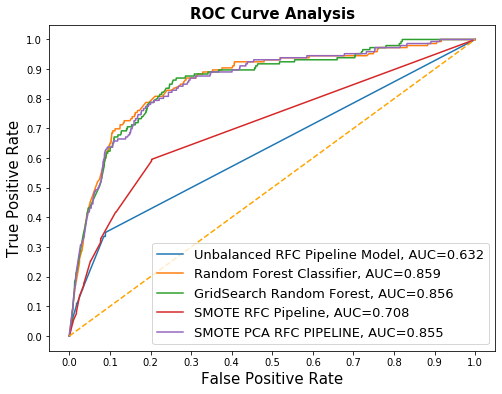

In [83]:
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

In [84]:
#Pipeline with Undersampling NearMiss For Resampling, PCA for feature selection & Random Forest as Classifier
nearmiss_pca_rfc_pipeline = make_pipeline_imb(NearMiss(return_indices=False, random_state=30), PCA(n_components=6), 
                                              RandomForestClassifier(random_state=30, max_depth= 8,n_estimators= 12))

nearmiss_pca_rfc_pipeline_model = nearmiss_pca_rfc_pipeline.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_nearmiss_pca_rfc_pipeline = nearmiss_pca_rfc_pipeline_model.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_nearmiss_pca_rfc_pipeline)

Accuracy is  0.05419839778459104
Precision Score is  0.01232522009321595
F1 Score is  0.024283236404448526
Recall Score is  0.815068493150685
Area under ROC Curve is  0.4290595852607414
Confusion Matrix is 
119 9536
27 429
Classification Report is 
              precision    recall  f1-score   support

           0       0.94      0.04      0.08      9965
           1       0.01      0.82      0.02       146

    accuracy                           0.05     10111
   macro avg       0.48      0.43      0.05     10111
weighted avg       0.93      0.05      0.08     10111



In [85]:
classifiers['Nearmiss PCA RFC MOdel'] = nearmiss_pca_rfc_pipeline_model

In [101]:
classifiers.keys()

dict_keys(['Unbalanced RFC Pipeline Model', 'Random Forest Classifier', 'GridSearch Random Forest', 'SMOTE RFC Pipeline', 'SMOTE PCA RFC PIPELINE', 'Nearmiss PCA RFC MOdel'])

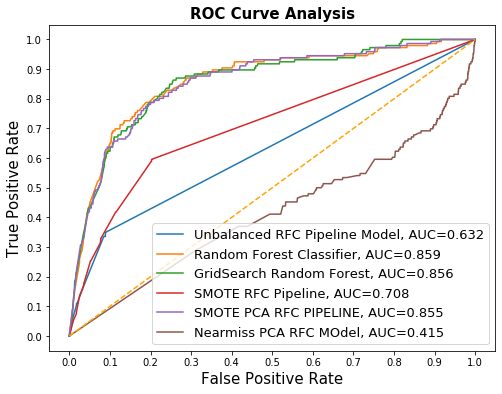

In [86]:
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

In [87]:
#Pipeline with SMOTE For Resampling, PCA for feature selection & Random Forest as Classifier
smoteenn_rfc_pipeline = make_pipeline_imb(SMOTEENN(random_state=30), RandomForestClassifier(max_depth= 9,n_estimators= 12))

smoteenn_rfc_pipeline_model = smoteenn_rfc_pipeline.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_smoteenn_rfc_pipeline = smoteenn_rfc_pipeline_model.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_smoteenn_rfc_pipeline)

Accuracy is  0.8280090990010879
Precision Score is  0.06067291781577496
F1 Score is  0.11230219499744767
Recall Score is  0.7534246575342466
Area under ROC Curve is  0.7912632570159944
Confusion Matrix is 
110 1703
36 8262
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      9965
           1       0.06      0.75      0.11       146

    accuracy                           0.83     10111
   macro avg       0.53      0.79      0.51     10111
weighted avg       0.98      0.83      0.89     10111



In [104]:
classifiers_smote['SMOTEEN RFC Pipeline'] = smoteenn_rfc_pipeline_model

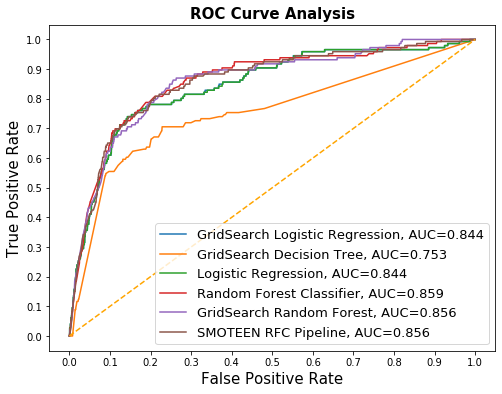

In [105]:
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers_smote))

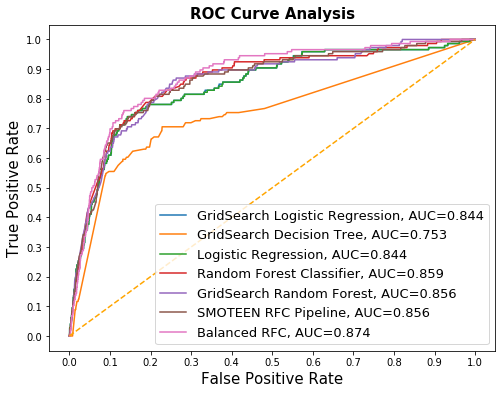

In [107]:
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers_smote))

In [88]:
#Imblearn BalancedRandomForestClassifier
bal_rfc = BalancedRandomForestClassifier(max_depth=8, random_state=30)

bal_rfc_model = bal_rfc.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_balance_rfc_model = bal_rfc_model.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_balance_rfc_model)

Accuracy is  0.7844921372762338
Precision Score is  0.05239982386613826
F1 Score is  0.09846917666528754
Recall Score is  0.815068493150685
Area under ROC Curve is  0.799556323845789
Confusion Matrix is 
119 2152
27 7813
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      9965
           1       0.05      0.82      0.10       146

    accuracy                           0.78     10111
   macro avg       0.52      0.80      0.49     10111
weighted avg       0.98      0.78      0.87     10111



In [106]:
classifiers_smote['Balanced RFC'] = bal_rfc_model

In [89]:
# Various models
log_reg_ensemble = LogisticRegression()
dt_ensemble = DecisionTreeClassifier(random_state=30)
rfc_ensemble = RandomForestClassifier(random_state=30)

model_list = [('log_reg_ensemble',log_reg_ensemble),('dt_ensemble',dt_ensemble),('rfc_ensemble',rfc_ensemble)]

# Code starts here
# Initialize voting classifier
voting_clf_soft = VotingClassifier(estimators=model_list,voting='soft')

# Fit the model on training data
voting_clf_soft.fit(X_train.iloc[ : , 1 : ], y_train)

y_pred_soft_voting = voting_clf_soft.predict(X_test.iloc[ : , 1 : ])

metric_data(y_test, y_pred_soft_voting)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is  0.9831866284244882
Precision Score is  0.038461538461538464
F1 Score is  0.011627906976744184
Recall Score is  0.00684931506849315
Area under ROC Curve is  0.5021702671679646
Confusion Matrix is 
1 25
145 9940
Classification Report is 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9965
           1       0.04      0.01      0.01       146

    accuracy                           0.98     10111
   macro avg       0.51      0.50      0.50     10111
weighted avg       0.97      0.98      0.98     10111



In [90]:
ensembling_classifer = {'Soft Voting Classifier' : voting_clf_soft}

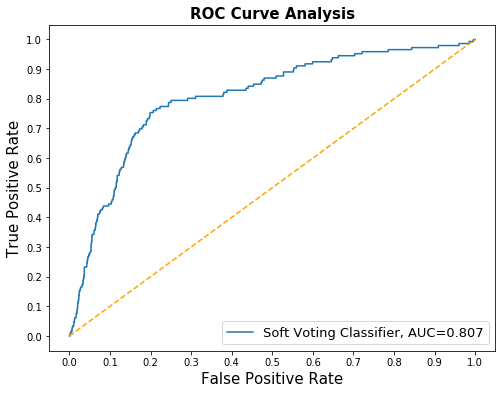

In [91]:
plot_roc_auc_curve(roc_auc_curve_plot_data(ensembling_classifer))

In [92]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), random_state=0,n_estimators=100,max_samples=100)

In [93]:
bagging_clf.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [94]:
y_pred_bagging_clf = bagging_clf.predict(X_test.iloc[ : , 1 : ])

In [95]:
metric_data(y_test, y_pred_bagging_clf)

Accuracy is  0.7829097023044209
Precision Score is  0.05203323130738959
F1 Score is  0.0978216193999178
Recall Score is  0.815068493150685
Area under ROC Curve is  0.7987535140113685
Confusion Matrix is 
119 2168
27 7797
Classification Report is 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      9965
           1       0.05      0.82      0.10       146

    accuracy                           0.78     10111
   macro avg       0.52      0.80      0.49     10111
weighted avg       0.98      0.78      0.87     10111



In [96]:
ensembling_classifer['Bagging Classifier'] = bagging_clf

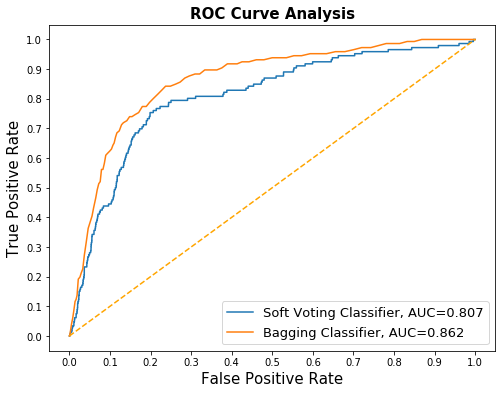

In [97]:
plot_roc_auc_curve(roc_auc_curve_plot_data(ensembling_classifer))

In [98]:
classifier1 = LogisticRegression(C=0.01)
classifier2= RandomForestClassifier(random_state=40,criterion='gini',max_depth=8)

classifier_list=[classifier1,classifier2]

# meta-classifier
m_classifier=RandomForestClassifier(random_state=42,criterion='entropy',max_depth=6)


stacking_clf = StackingClassifier(classifiers=classifier_list, meta_classifier=m_classifier)

stacking_clf.fit(X_train_res,y_train_res)

NameError: name 'StackingClassifier' is not defined

In [ ]:
y_pred_Stacking = stacking_clf.predict(X_test.iloc[ : , 1 :])

In [ ]:
metric_data(y_test, y_pred_Stacking)

In [ ]:
def predict_data(model):
    model.fit(X_train.iloc[ : , 1 : ], y_train)
    y_pred = model.predict(X_test.iloc[ : , 1 : ])
    metric_data(y_test, y_pred)
    return y_pred

In [ ]:
classifier_list=[rfc,grid_search_log_reg, smote_pca_rfc_pipeline_model, smoteenn_rfc_pipeline_model]

# meta-classifier
m_classifier=RandomForestClassifier(random_state=42,criterion='entropy',max_depth=6)


stacking_clf = StackingClassifier(classifiers=classifier_list, meta_classifier=m_classifier)


In [ ]:
y_pred_temp = predict_data(stacking_clf)

In [ ]:
for splits in [2, 5, 10, 15, 20] :
    kfold = KFold(n_splits=splits, random_state=30, )
    for train, test in kfold.split(X_train, y_train):
        kfold_model = smote_rfc_pipeline.fit(X_train.iloc[train.ravel()], y_train.iloc[train.ravel()])
        y_pred_kfold = kfold_model.predict(X_train.iloc[test.ravel()])
        print('For Split of {}'.format(splits))
        metric_data(y_train.iloc[test.ravel()], y_pred_kfold)
        print('=='*25)

In [ ]:
2697 in X_train.index

In [ ]:
X_train.head()